Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [5]:
!ls

1_notmnist.ipynb          5_word2vec.ipynb          notMNIST_large.tar.gz
2_fullyconnected.ipynb    6_lstm.ipynb              notMNIST_sanitized.pickle
3_regularization.ipynb    notMNIST.pickle           notMNIST_small
4_convolutions.ipynb      notMNIST_large            notMNIST_small.tar.gz


In [6]:
import os, random
path = './notMNIST_small/B/'

In [7]:
filename = random.choice(os.listdir(path))
from IPython.display import Image
Image( filename=path + filename ) 

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [8]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [9]:
train_datasets

['./notMNIST_large/A.pickle',
 './notMNIST_large/B.pickle',
 './notMNIST_large/C.pickle',
 './notMNIST_large/D.pickle',
 './notMNIST_large/E.pickle',
 './notMNIST_large/F.pickle',
 './notMNIST_large/G.pickle',
 './notMNIST_large/H.pickle',
 './notMNIST_large/I.pickle',
 './notMNIST_large/J.pickle']

In [10]:
import pickle

A = pickle.load( open( train_datasets[0], "rb" ) )
len(A)

52909

7477


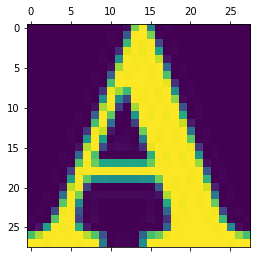

In [11]:
import matplotlib.pyplot as plt
from random import randint

index = randint(0, len(A)-1)
print(index)
plt.matshow(A[index])
plt.show()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [12]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [13]:
from collections import Counter
Counter(valid_labels)

Counter({0: 1000,
         1: 1000,
         2: 1000,
         3: 1000,
         4: 1000,
         5: 1000,
         6: 1000,
         7: 1000,
         8: 1000,
         9: 1000})

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [14]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [65]:
####

# label -> letter dictionary
new_labels={0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J'}

# The subplot() command specifies numrows, numcols, fignum where fignum ranges from 1 to numrows*numcols.

def disp_sample_dataset(dataset, labels):
    #pick 8 random indices
    items_indices = random.sample(range(len(labels)), 8)
    #print(items_indices)
    for i, index in enumerate(items_indices):
        #print(i, index)
        
        plt.subplot(2, 4, i+1) #fignum starts with 1
        plt.axis('off')
        plt.title(new_labels[labels[index]]) #label array is numbers, make it a letter
        plt.imshow(dataset[index])

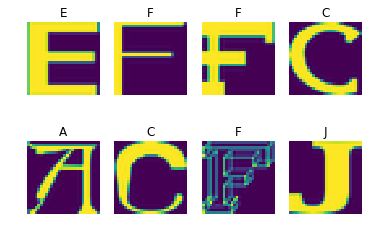

In [16]:
disp_sample_dataset(train_dataset, train_labels)

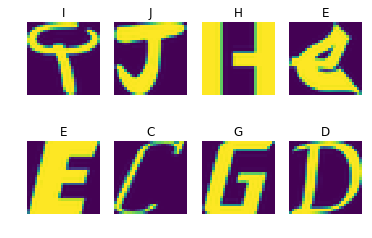

In [17]:
disp_sample_dataset(valid_dataset, valid_labels)

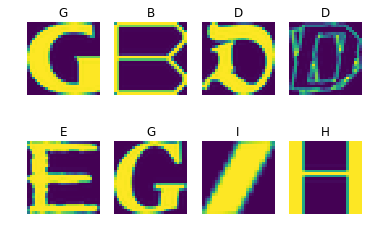

In [18]:
disp_sample_dataset(test_dataset, test_labels)

Finally, let's save the data for later reuse:

In [19]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [20]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5: Measure Overlap
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [21]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [22]:
####

# [1] Nested For Loop

def extract_overlap(dataset_1, dataset_2):
    overlap = {}
    for i, img_1 in enumerate(dataset_1):
        for j, img_2 in enumerate(dataset_2):
            if np.array_equal(img_1, img_2):
                if not i in overlap.keys():
                    overlap[i]=[]
                overlap[i].append(j)
    return overlap

In [23]:
%time overap_test_train = extract_overlap(test_dataset[:200], train_dataset)

CPU times: user 2min 39s, sys: 232 ms, total: 2min 39s
Wall time: 2min 39s


In [24]:
len(overap_test_train.keys())

24

In [25]:
####
def display_overlap(overlapdict, source, target):
    imgs = []
    
    while(len(imgs)<3):
        #pick a random index from source data (i.e. a key from overlapdict)
        source_index = random.choice(list(overlapdict.keys()))
        #pick atmost 7 duplicate images from target database
        imgs = np.concatenate(([source[source_index]], target[overlapdict[source_index][0:7]]))
    
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i+1)
        plt.imshow(img)

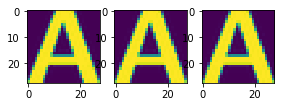

In [26]:
display_overlap(overap_test_train, test_dataset[:200], train_dataset)

In [27]:
test_flat = test_dataset.reshape(test_dataset.shape[0], 28*28)
print(test_flat.shape)
norm = np.sum(np.abs(test_flat), axis = 1) #sum of each column
print(len(np.where(norm > 360)[0]))
#norm[0:10]

(10000, 784)
2931


In [28]:
####
# reduce 2 for loops to 1 for loop

MAX_MANHATTAN_NORM = 10

def extract_overlap_where(dataset1, dataset2):
    #key diff is the each image has been flattened before sending to this function
    overlap={}
    for i, img_1 in enumerate(dataset1):
        diff = dataset2 - img_1
        norm = np.sum(np.abs(diff), axis=1)
        #only pick the indices where norm is less that MAX_MANHATTAN_NORM
        duplicates = np.where(norm < MAX_MANHATTAN_NORM)
        if len(duplicates[0]):
            overlap[i] = duplicates[0] #attach whole list to this key
    return overlap

In [29]:
####
#flatten
test_flat = test_dataset.reshape(test_dataset.shape[0], 28*28)
train_flat = train_dataset.reshape(train_dataset.shape[0], 28*28)

In [30]:
%time overlap_test_train = extract_overlap_where(test_flat[:200], train_flat)

CPU times: user 1min 12s, sys: 1min 30s, total: 2min 43s
Wall time: 2min 43s


In [31]:
print('Number of overlaps:', len(overlap_test_train.keys()))

Number of overlaps: 53


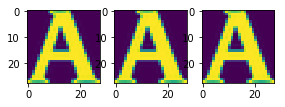

In [32]:
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

In [33]:
####
#find overlaps using hash table
#hash function = hashlib.sha256()

import hashlib

def extract_overlap_hash(dataset1, dataset2):
    dataset_hash_1 = [hashlib.sha256(img).hexdigest() for img in dataset1]
    dataset_hash_2 = [hashlib.sha256(img).hexdigest() for img in dataset2]
    overlap = {}
    for i, hash1 in enumerate(dataset_hash_1):
        for j, hash2 in enumerate(dataset_hash_2):
            if hash1 == hash2:
                if not i in overlap.keys():
                    overlap[i] = []
                overlap[i].append(j)
    return overlap

In [34]:
%time overlap_test_train = extract_overlap_hash(test_dataset[:200], train_dataset)

CPU times: user 3.66 s, sys: 18.2 ms, total: 3.68 s
Wall time: 3.68 s


In [35]:
len(overlap_test_train.keys())

24

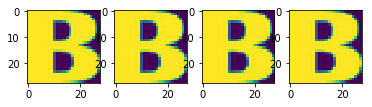

In [36]:
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

In [37]:
####
#find overlaps using hash table
#hash function = hashlib.sha256() with singl for loop

import hashlib

def extract_overlap_hash(dataset1, dataset2):
    dataset_hash_1 = [hashlib.sha256(img).hexdigest() for img in dataset1]
    #print(dataset_hash_1[0])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset2])
    overlap = {}
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1) #sequence should be np.array for this to work
        #print(duplicates)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

In [38]:
%time overlap_test_train = extract_overlap_hash(test_dataset[:200], train_dataset)
#len(overlap_test_train)

CPU times: user 2.77 s, sys: 48.6 ms, total: 2.82 s
Wall time: 2.82 s


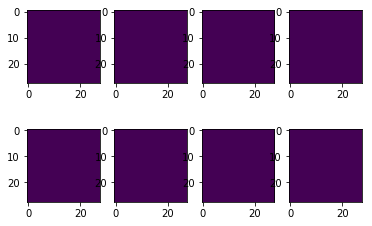

In [39]:
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

In [40]:
np.delete([1,2,3,4,5], [0,2], None)

array([2, 4, 5])

In [92]:
def sanitize(dataset1, dataset2, labels1):
    #cleans dataset1 by removing all samples that also occur in dataset2
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset2])
    overlap = []
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap.append(i)
    return np.delete(dataset1, overlap, 0), np.delete(labels1, overlap, 0)

In [42]:
%time test_san, test_labels_san = sanitize(test_dataset[:200], train_dataset, test_labels[:200])

CPU times: user 2.71 s, sys: 39.7 ms, total: 2.75 s
Wall time: 2.75 s


In [43]:
print(len(test_dataset[:200]) - len(test_san))

24


In [44]:
#### compare test with train and clean test
%time test_san, test_labels_san = sanitize(test_dataset, train_dataset, test_labels)

CPU times: user 53.3 s, sys: 146 ms, total: 53.5 s
Wall time: 53.5 s


In [45]:
#### compare valid with train and clean valid
%time valid_san, valid_labels_san = sanitize(valid_dataset, train_dataset, valid_labels)

CPU times: user 52.6 s, sys: 148 ms, total: 52.8 s
Wall time: 52.8 s


In [46]:
#also remove any overlaps of validation set with test set
%time valid_minus_test_san, valid_minus_test_labels_san = sanitize(valid_san, test_dataset, valid_labels_san)

CPU times: user 843 ms, sys: 8.24 ms, total: 852 ms
Wall time: 847 ms


In [47]:
len(valid_san) - len(valid_minus_test_san)

37

In [48]:
len(train_dataset), len(train_labels)

(200000, 200000)

In [49]:
len(valid_dataset) - len(valid_minus_test_san), len(valid_minus_test_san), len(valid_minus_test_labels_san)

(1104, 8896, 8896)

In [50]:
len(test_dataset) - len(test_san), len(test_san), len(test_labels_san)

(1324, 8676, 8676)

In [51]:
store_filename = 'notMNIST_sanitized.pickle'

try:
    f = open(store_filename, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels' : train_labels,
        'valid_dataset': valid_minus_test_san,
        'valid_labels' : valid_minus_test_labels_san,
        'test_dataset' : test_san,
        'test_labels'  : test_labels_san
    }
    
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print("e")
    raise

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [52]:
model = LogisticRegression()

In [55]:
samples = test_dataset.shape[0]

In [56]:
X_test = test_dataset.reshape(samples, 28*28)

In [57]:
y_test = test_labels

In [70]:
#### take first 50 samples for training

In [76]:
def train_score(sample_size, X_report, y_report):
    global model
    X_train = train_dataset[:sample_size].reshape(sample_size, 28*28)
    y_train = train_labels[:sample_size]
    model.fit(X_train, y_train)
    print(model.score(X_report, y_report))

In [83]:
sample_size = 50
train_score(sample_size, X_test, y_test)

0.509


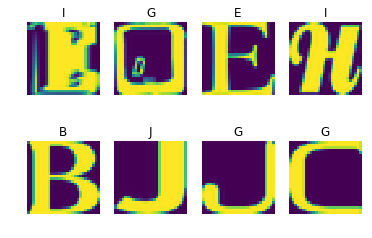

In [73]:
pred_labels = model.predict(X_test)
disp_sample_dataset(test_dataset, pred_labels)

In [84]:
sample_size = 100
train_score(sample_size, X_test, y_test)

0.6966


In [85]:
sample_size = 1000
train_score(sample_size, X_test, y_test)

0.8333


In [86]:
X_valid = valid_dataset[:sample_size].reshape(sample_size, 28*28)
y_valid = valid_labels[:sample_size]

In [87]:
model.score(X_valid, y_valid)

0.73599999999999999

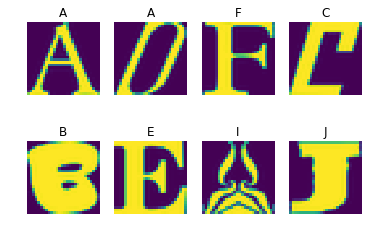

In [88]:
pred_validation_labels = model.predict(X_valid)
disp_sample_dataset(valid_dataset, pred_validation_labels)

In [89]:
train_score(5000, X_test, y_test)

0.8511


In [91]:
model = LogisticRegression(solver = 'sag')
%time train_score(len(train_dataset), X_test, y_test)

0.8932
CPU times: user 16min 46s, sys: 6.93 s, total: 16min 53s
Wall time: 16min 57s
